<a href="https://colab.research.google.com/github/paulyu8868/AI_Project_ResNet50/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8(%EC%8A%A4%ED%8F%AC%EC%B8%A0%EC%9D%B4%EB%AF%B8%EC%A7%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960  # 다운로드할 때 사용할 청크 크기 정의
DATA_SOURCE_MAPPING = 'sports-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209061%2F5595172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T083516Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4ff27212829aa64ab0b5cf437110047d79b80eebd8419af6b2b44c6edb7e667356b582b4bf29dbab8aa14ab9702f75ffb9de00a948c9d8332fcbe640bd02bde694b71984dbc3a073b72848fc551d4af2471289149cb3bf8dbafbbcdd365793c3b58dcf2ff4e378ee32ddcbadc52b374b2f4196a3d3f7f25f7ab93923079cf17680dd6796fb427023eb46e56c335745f3b58897f1de47ac0141d64a7030e01dc5b595238ba2b681a0e02fe4393d4fd7e415c6079f979ee924875d8733197c5369884e61beb1bf0a0154efc10aa636544118be4cf99d14fe5420ddad142cbb10bacda2fcbd3e289286505063551857b12dca7ff04b8eba68cbf599b2a22654fc85'
# 데이터 소스 URL 인코딩

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

# 이전에 마운트된 /kaggle/input을 언마운트하고 내용 제거
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
# 입력 및 작업 경로를 위한 디렉토리 생성
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# 입력 및 작업 경로에 대한 심볼릭 링크 생성
try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

# 각 데이터 소스 매핑을 순회
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'{directory} 다운로드 중, {total_length} 바이트 압축됨')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} 바이트 다운로드됨")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            # 파일 확장자에 따라 압축 해제
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\n{directory} 다운로드 및 압축 해제 완료')
    except HTTPError as e:
        print(f'(만료 가능성 높음) {download_url} 로드 실패, 경로: {destination_path}')
        continue
    except OSError as e:
        print(f'{download_url} 로드 실패, 경로: {destination_path}')
        continue

print('데이터 소스 가져오기 완료')
# 완료 메시지 출력


sports-classification 다운로드 중, 444540604 바이트 압축됨
[==================================================] 444540604 바이트 다운로드됨
sports-classification 다운로드 및 압축 해제 완료
데이터 소스 가져오기 완료


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
# 필요한 라이브러리 및 모듈 임포트

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
# 케라스에서 레이어, 모델, 옵티마이저 임포트

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 이미지 데이터 증강을 위한 ImageDataGenerator 임포트

from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
# 케라스 레이어에서 Input, Dense, Flatten, GlobalAveragePooling2D 임포트

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# 학습 중 콜백 기능을 위한 Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 임포트

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# 성능 평가를 위한 classification_report, confusion_matrix, accuracy_score 임포트

from tensorflow.keras.optimizers import Adam
# 옵티마이저로 Adam 임포트


# Loading the Data

In [ ]:
train_dir = '/kaggle/input/sports-classification/train'
# 학습 데이터가 저장된 디렉토리 경로 설정

test_dir= '/kaggle/input/sports-classification/test'
# 테스트 데이터가 저장된 디렉토리 경로 설정

val_dir = '/kaggle/input/sports-classification/valid'
# 검증 데이터가 저장된 디렉토리 경로 설정


**Let's Create A function to show us some random images with thier labels**

In [ ]:
def show_random_images_with_labels(main_folder, num_images=5):
  """
  주 폴더의 하위 폴더에서 무작위로 선택된 이미지와 해당 레이블(하위 폴더 이름)을 표시합니다.

  Args:
    main_folder: 이미지가 포함된 하위 폴더가 있는 주 폴더의 경로.
    num_images: 표시할 이미지 수 (기본값: 5).
  """

  subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
  # 주 폴더 내의 하위 폴더 경로를 리스트로 생성

  random.shuffle(subfolders)  # 하위 폴더 순서를 무작위로 섞음

  fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
  # num_images 수만큼 서브플롯을 생성 (1행 num_images열)

  for i, subfolder in enumerate(subfolders[:num_images]):
    # num_images 개수만큼 하위 폴더를 순회
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # 하위 폴더 내의 모든 이미지 파일 경로를 리스트로 생성

    random.shuffle(image_paths)  # 하위 폴더 내 이미지 파일 경로 순서를 무작위로 섞음

    image_path = image_paths[0]  # 무작위로 선택된 첫 번째 이미지 경로를 선택

    img = Image.open(image_path)
    # 선택된 이미지를 열기

    axes[i].imshow(img)
    # 이미지를 현재 서브플롯에 표시

    axes[i].axis('off')
    # 축 눈금을 비활성화

    axes[i].set_title(os.path.basename(image_path) + f" ({os.path.basename(subfolder)})", fontsize=10)
    # 이미지 파일명과 하위 폴더명을 서브플롯 제목으로 설정

  plt.tight_layout()
  # 서브플롯 간의 레이아웃을 조정

  plt.show()
  # 플롯을 화면에 출력


In [1]:
# 임의의 이미지와 레이블을 표시하는 함수 호출
show_random_images_with_labels(train_dir, 5)


NameError: name 'show_random_images_with_labels' is not defined

# Create an ImageDataGenerator for Training / Validating and Testing data

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2)
# 이미지 증강을 위한 ImageDataGenerator 객체 생성
# - zoom_range: 이미지 확대 비율 설정
# - width_shift_range: 이미지 가로 이동 비율 설정ㅁ
# - height_shift_range: 이미지 세로 이동 비율 설정

train_dg = train_datagen.flow_from_directory(train_dir,
                                             class_mode="categorical",
                                             target_size=(299, 299),
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)
# train_dir 경로에서 이미지를 불러와서 데이터 증강
# - class_mode: "categorical"로 설정하여 다중 클래스 레이블을 생성
# - target_size: 모든 이미지를 (299, 299) 크기로 조정
# - batch_size: 배치 크기를 128로 설정
# - shuffle: 데이터를 무작위로 섞음
# - seed: 무작위성 재현을 위한 시드 값 설정


Found 13492 images belonging to 100 classes.


In [ ]:
val_datagen = ImageDataGenerator()
# 검증 데이터는 증강 없이 로드하기 위한 ImageDataGenerator 객체 생성

validation_dg = val_datagen.flow_from_directory(val_dir,
                                                class_mode="categorical",
                                                target_size=(299, 299),
                                                batch_size=128,
                                                shuffle=False,
                                                seed=42)
# val_dir 경로에서 검증 데이터를 불러옴
# - class_mode: "categorical"로 설정하여 다중 클래스 레이블을 생성
# - target_size: 모든 이미지를 (299, 299) 크기로 조정
# - batch_size: 배치 크기를 128로 설정
# - shuffle: 데이터를 무작위로 섞지 않음
# - seed: 무작위성 재현을 위한 시드 값 설정


Found 500 images belonging to 100 classes.


In [ ]:
testing_dg = val_datagen.flow_from_directory(test_dir,
                                             class_mode="categorical",
                                             target_size=(299, 299),
                                             batch_size=128,
                                             shuffle=False,
                                             seed=42)
# test_dir 경로에서 테스트 데이터를 불러옴
# - class_mode: "categorical"로 설정하여 다중 클래스 레이블을 생성
# - target_size: 모든 이미지를 (299, 299) 크기로 조정
# - batch_size: 배치 크기를 128로 설정
# - shuffle: 데이터를 무작위로 섞지 않음
# - seed: 무작위성 재현을 위한 시드 값 설정


Found 500 images belonging to 100 classes.


# Create Basic CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
# Conv layer (relu) 패딩적용
model.add(Conv2D(input_shape=(299, 299, 3), filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
# max pooling : stride(2x2) (overfittiong 방지)
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatten the image into a 1D array using the Flatten layer
model.add(Flatten())
# Fully connected layers
model.add(Dense(units=256, activation="relu"))
# 아웃풋 레이어 (softmax)
model.add(Dense(units=100, activation="softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 299, 299, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 149, 149, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 128)       7

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
checkpoint_cb = ModelCheckpoint('best-cnn-model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    train_dg,
    epochs=1,
    validation_data=validation_dg,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


106/106 [==============================] - 342s 3s/step - loss: 32.7949 - accuracy: 0.0279 - val_loss: 4.2057 - val_accuracy: 0.0540


# Use ResNet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# ImageNet 데이터셋으로 사전 학습된 ResNet50 모델 불러오기
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# 분류를 위한 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x) # Global Avg pooling 사용
x = Dropout(0.25)(x) # 과적합 방지

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=Dense(100, activation="softmax")(x))



94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam

# Adam 옵티마이저를 사용하여 학습률 0.005로 설정
opt = Adam(learning_rate=0.005)

# 모델 컴파일
model.compile(optimizer=opt,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# - optimizer: 설정한 Adam 옵티마이저 사용
# - loss: 다중 클래스 분류를 위한 categorical_crossentropy 손실 함수 사용
# - metrics: 모델 평가를 위한 정확도(accuracy) 메트릭 사용


In [ ]:
history = model.fit(
      train_dg,
      epochs=10,
      validation_data = validation_dg,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/10
106/106 [==============================] - 335s 3s/step - loss: 2.1678 - accuracy: 0.5148 - val_loss: 0.7069 - val_accuracy: 0.7760 - lr: 0.0050
Epoch 2/10
106/106 [==============================] - 309s 3s/step - loss: 0.9985 - accuracy: 0.7220 - val_loss: 0.6476 - val_accuracy: 0.8080 - lr: 0.0050
Epoch 3/10
106/106 [==============================] - 308s 3s/step - loss: 0.7575 - accuracy: 0.7844 - val_loss: 0.5077 - val_accuracy: 0.8400 - lr: 0.0050
Epoch 4/10
106/106 [==============================] - 309s 3s/step - loss: 0.7290 - accuracy: 0.7958 - val_loss: 0.5534 - val_accuracy: 0.8500 - lr: 0.0050
Epoch 5/10
106/106 [==============================] - 311s 3s/step - loss: 0.6588 - accuracy: 0.8158 - val_loss: 0.4961 - val_accuracy: 0.8520 - lr: 0.0050
Epoch 6/10
106/106 [==============================] - 309s 3s/step - loss: 0.5994 - accuracy: 0.8289 - val_loss: 0.4587 - val_accuracy: 0.8740 - lr: 0.0050
Epoch 7/10
106/106 [==============================] - 310s 3s/st

# Plotting Our Metrics

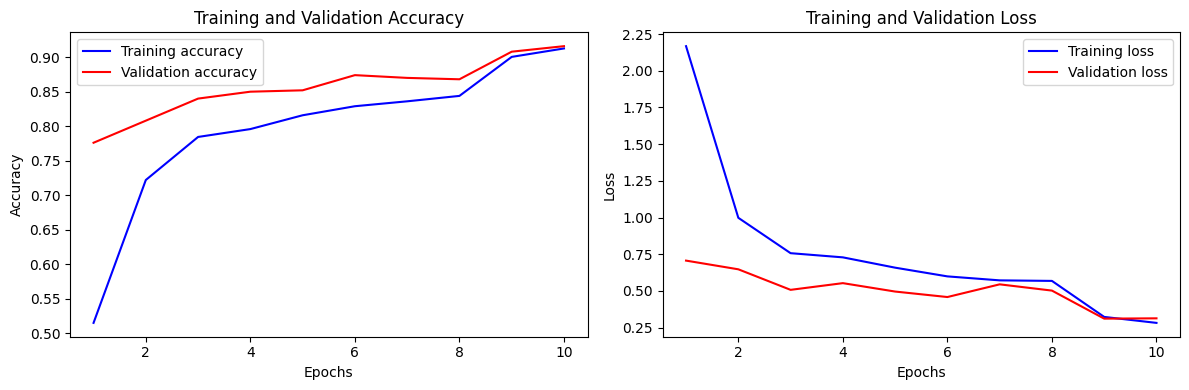

In [ ]:
# 학습과 검증 메트릭을 history 객체에서 추출
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')  # 학습 정확도 플롯
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')  # 검증 정확도 플롯
plt.title('Training and Validation Accuracy')  # 제목 설정
plt.xlabel('Epochs')  # x축 레이블 설정
plt.ylabel('Accuracy')  # y축 레이블 설정
plt.legend()  # 범례 표시

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')  # 학습 손실 플롯
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 검증 손실 플롯
plt.title('Training and Validation Loss')  # 제목 설정
plt.xlabel('Epochs')  # x축 레이블 설정
plt.ylabel('Loss')  # y축 레이블 설정
plt.legend()  # 범례 표시

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시


# Evaluating the model's performance on the test dataset.

In [ ]:
# 테스트 데이터 제네레이터를 사용하여 모델 평가
predictions = model.evaluate(testing_dg)

# CNN Model
# 평가 결과 출력
print(f"Test Loss: {predictions[0]}")
print(f"Test Accuracy: {predictions[1]}")


4/4 [==============================] - 3s 734ms/step - loss: 0.3119 - accuracy: 0.9160
Test Loss: 0.3119038939476013
Test Accuracy: 0.9160000085830688


In [ ]:
# 테스트 데이터의 실제 레이블 가져오기
true_labels = testing_dg.classes

# 모델을 사용하여 예측한 클래스 레이블 가져오기
predicted_labels = np.argmax(model.predict(testing_dg), axis=1)

# 분류 보고서 출력
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=list(testing_dg.class_indices.keys())))


4/4 [==============================] - 3s 753ms/step
Classification Report:
                        precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.80      0.80      0.80         5
           basketball       0.80      0.80      0.80         5
       baton twirling       1.00      0.40      0.57         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      0.

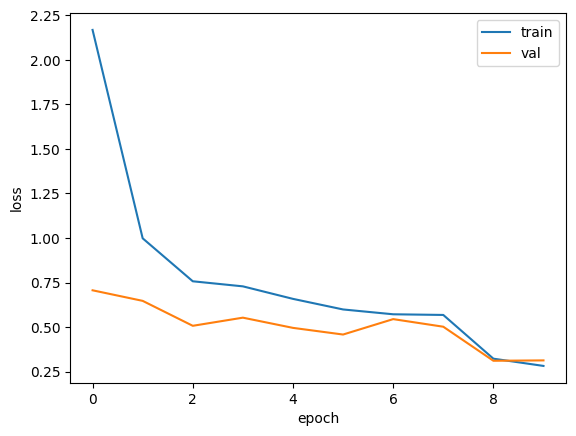

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()